# Lassa data set evaluation

In [6]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
def histograms(stats):
    # Creating histograms with custom labels
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))  # Adjust grid if you have a different layout

    stats[['N_share', 'Length', 'RelativeLength', 'RelativeError']].hist(
        bins=50, log=True, ax=axes
    )

    # Setting y-axis label for the left column
    axes[0].set_ylabel('Number of sequences')

    axes[0].set_xlim(0, 1)
    axes[1].set_xlim(left=0)
    axes[2].set_xlim(left=0)
    axes[3].set_xlim(0, 1)

    # Setting x-axis labels with the feature names
    features = ['N_share', 'Length', 'RelativeLength', 'RelativeError']
    for ax, feature in zip(axes.flatten(), features):
        ax.set_xlabel(feature)
        ax.set_title('')  # Remove the title above each plot

    plt.tight_layout()
    plt.show()

## Data ingestion.

We compute the following features
- the relative length of the sequence compared to the reference
- edit distance in relation to the match length
- the amount of the reference covered by the alignment
- the amount of the query covered by the alignment

In [108]:
fname_stats = "../data/lassa/all/collected_stats.tsv"
seqstats = pd.read_csv(fname_stats, sep='\t')
seqstats['RelativeLength'] = seqstats['Length'] / seqstats['ReferenceLength']
seqstats['RelativeError'] = seqstats['EditDistance'] / (seqstats['ReferenceEnd'] - seqstats['ReferenceStart'])
seqstats['ReferenceCoverage'] = (seqstats['ReferenceEnd'] - seqstats['ReferenceStart']) / seqstats['ReferenceLength']
seqstats['QueryCoverage'] = (seqstats['QueryEnd'] - seqstats['QueryStart']) / seqstats['Length']

seqstats

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
0,AY179171.1,FR832710.1,True,20.0,7247.0,0.0,7227.0,0.0,False,0.0,7227,7267.0,L,0.994496,0.000000,0.994496,1.0
1,FR832710.1,FR832710.1,True,0.0,7267.0,0.0,7267.0,0.0,False,0.0,7267,7267.0,L,1.000000,0.000000,1.000000,1.0
2,GU573541.1,FR832710.1,False,3417.0,4171.0,0.0,754.0,92.0,False,0.0,754,7267.0,L,0.103757,0.122016,0.103757,1.0
3,GU573542.1,FR832710.1,False,3417.0,4171.0,0.0,754.0,91.0,False,0.0,754,7267.0,L,0.103757,0.120690,0.103757,1.0
4,GU573543.1,FR832710.1,False,3417.0,4171.0,0.0,754.0,91.0,False,0.0,754,7267.0,L,0.103757,0.120690,0.103757,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,LC388587.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN
2812,LC388588.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN
2813,LC388589.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN
2814,MT119502.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,223,NaN,NaN,NaN,NaN,NaN,NaN


Overall length and N_share distribution before any filtering has happened.

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

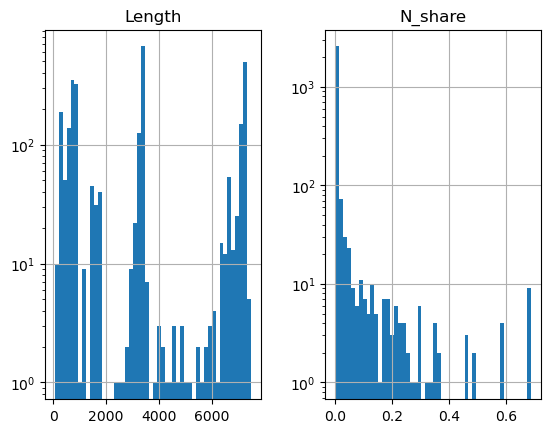

In [109]:
seqstats[['Length', 'N_share']].hist(bins=50, log=True)

## Removing unaligned sequences.

We remove all sequences that were not mapped. Let's have a look at the 10 largest sequences first.

In [110]:
unmapped = seqstats[seqstats['IsForward'].isna()][['Sequence', 'Length', 'N_share']]
print(f'Number of unmapped reads={len(unmapped)}')
unmapped.nlargest(10, ['Length'])

Number of unmapped reads=17


,Sequence,Length,N_share
2810,JQ511992.1,281,0.0
2811,LC388587.1,281,0.0
2812,LC388588.1,281,0.0
2813,LC388589.1,281,0.0
2799,HM143866.1,237,0.0
2803,JN651370.1,237,0.0
2800,HM143867.1,234,0.0
2801,HM143876.1,234,0.0
2802,HM143879.1,234,0.0
2804,JN651374.1,234,0.0


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

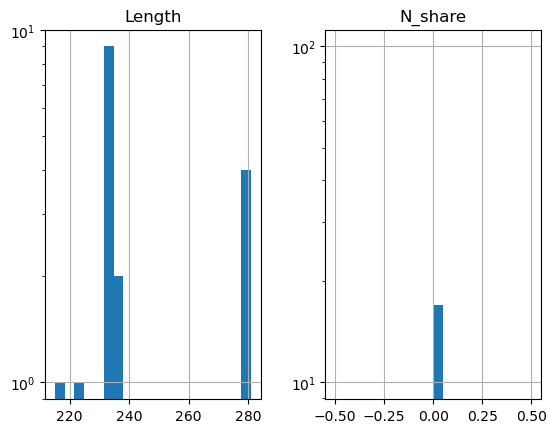

In [111]:
unmapped.hist(bins=20, log=True)

In [112]:
seqstats_mapped = seqstats.dropna(subset='Reference')

## Removing supplementary alignments

Additional to the best hit, minimap2 also sometimes computes supplementary alignments. We remove them here.

In [113]:
seqstats_primary = seqstats_mapped[seqstats_mapped['IsSupplementaryAlignment'] == False]

## Remove short sequences and those with too many Ns

In [128]:
minlen = 2000
max_n_share = 0.05

seqstats_minlen = seqstats_mapped[seqstats_mapped['Length'] >= minlen]
seqstats_high_coverage = seqstats_minlen[seqstats_minlen['N_share'] <= max_n_share]

print('Before filtering:', len(seqstats_mapped))
print(f'N-share larger than {max_n_share}:', len(seqstats_mapped[seqstats_mapped['N_share'] > max_n_share]))
print(f'Length smaller than {minlen}:', len(seqstats_mapped[seqstats_mapped['Length'] < minlen]))
print('After filtering:', len(seqstats_high_coverage))

Before filtering: 2799
N-share larger than 0.05: 127
Length smaller than 2000: 1165
After filtering: 1520


## Remove too short genomes
We remove the genomes that are too short compared to the reference genome.

In [129]:
min_relative_length = 0.95
seqstats_long_seqs = seqstats_high_coverage[seqstats_high_coverage['RelativeLength'] > min_relative_length]
print(f'{len(seqstats_long_seqs)} sequences remain of {len(seqstats_high_coverage)}')

1392 sequences remain of 1520


Additionally we remove all sequences, where the alignment does not cover enough of the target genome.

In [130]:
seqstats_long_seqs.nsmallest(10, ['ReferenceCoverage'])

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
2650,AH012598.2,OL774860.1,True,177.0,445.0,0.0,268.0,51.0,True,0.013839,7226,7170.0,L,1.007810,0.190299,0.037378,0.037088
2701,MZ169794.1,OL774860.1,False,177.0,445.0,0.0,268.0,55.0,True,0.016330,7226,7170.0,L,1.007810,0.205224,0.037378,0.037088
58,KF478769.1,FR832711.1,True,558.0,702.0,0.0,144.0,14.0,True,0.000000,3364,3392.0,S,0.991745,0.097222,0.042453,0.042806
54,KF478766.1,FR832711.1,True,1672.0,1847.0,0.0,175.0,20.0,True,0.000000,3561,3392.0,S,1.049823,0.114286,0.051592,0.049143
2618,FV537334.1,NC_004297.1,True,671.0,7269.0,671.0,7269.0,1488.0,False,0.000000,7279,7279.0,L,1.000000,0.225523,0.906443,0.906443
2619,FV537335.1,NC_004297.1,True,671.0,7269.0,671.0,7269.0,1488.0,False,0.000000,7279,7279.0,L,1.000000,0.225523,0.906443,0.906443
2700,MZ169794.1,OL774860.1,True,585.0,7163.0,64.0,6627.0,1625.0,False,0.016330,7226,7170.0,L,1.007810,0.247036,0.917434,0.908248
2649,AH012598.2,OL774860.1,False,584.0,7163.0,63.0,6627.0,1652.0,False,0.013839,7226,7170.0,L,1.007810,0.251102,0.917573,0.908386
1117,MH053532.1,GU481069.1,True,466.0,7127.0,388.0,7049.0,1156.0,False,0.031560,7161,7230.0,L,0.990456,0.173548,0.921300,0.930177
1118,MH053534.1,GU481069.1,True,464.0,7127.0,378.0,7041.0,1163.0,False,0.043758,7153,7230.0,L,0.989350,0.174546,0.921577,0.931497


In [131]:
min_ref_cov = 0.8
seqstats_min_ref_cov = seqstats_long_seqs[seqstats_long_seqs['ReferenceCoverage'] >= min_ref_cov]
print(f'Keeping {len(seqstats_min_ref_cov)} of {len(seqstats_long_seqs)} sequences')

Keeping 1388 of 1392 sequences


## Per reference genome counts
Let's have a look what is left after filtering with respect to the distinct reference genomes.

In [132]:
ref_counts_raw = seqstats_primary['Reference'].value_counts()
ref_counts_minlen = seqstats_minlen['Reference'].value_counts()
ref_counts_high_cov = seqstats_high_coverage['Reference'].value_counts()
ref_counts_filtered = seqstats_min_ref_cov['Reference'].value_counts()
pd.DataFrame({'Raw': ref_counts_raw, 'MinLen': ref_counts_minlen, 'MaxN': ref_counts_high_cov,  'Filtered': ref_counts_filtered})

,Raw,MinLen,MaxN,Filtered
Reference,,,,
FR832710.1,37,14,14,6
FR832711.1,57,11,11,9
GU481068.1,853,530,508,477
GU481069.1,499,508,439,395
HQ688672.1,378,70,66,66
HQ688674.1,222,194,178,152
KM822127.1,3,2,2,2
KM822128.1,7,5,5,5
KT992425.1,8,2,2,2


## Statistics after filtering

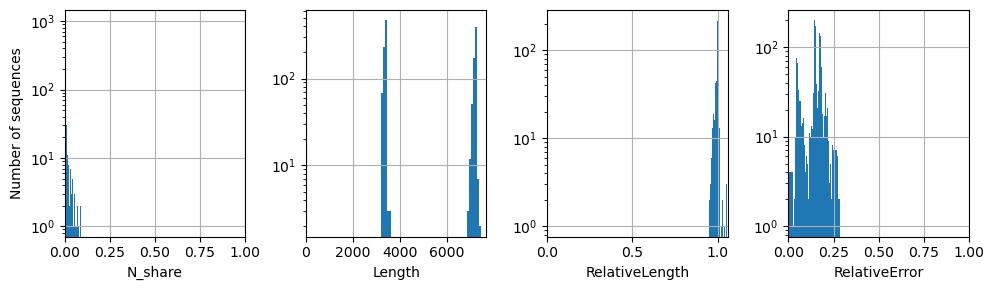

In [119]:
histograms(seqstats_min_ref_cov)

## Read orientation
Finally, lets get the filtered reads with harmonized orientation sorted into the Segments.

In [120]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

df_filtered_final = seqstats_min_ref_cov
outdir = '../data/lassa/filtered'
os.makedirs(outdir, exist_ok=True)

segments = sorted(set(df_filtered_final['Segment'])) 
fname_sequences = '/Volumes/DataCurate/CurationDatasets/Lassa/lassa_ncbi_20241024.fasta'
fname_template_out = os.path.join(outdir, "filtered_segment_{}.fasta")

outfiles = {
    segment: open(fname_template_out.format(segment), 'w')
    for segment in segments
}

segment_and_orientation = {
    row['Sequence']: (row['IsForward'], row['Segment'])
    for _, row in df_filtered_final.iterrows()
}

for record in SeqIO.parse(fname_sequences, "fasta"):
    if record.id not in segment_and_orientation:
        continue
    is_forward, segment = segment_and_orientation[record.id]
    if is_forward is None:
        raise RuntimeError(f"Invalid orientation {is_forward}")
    orientation = 'forward' if is_forward else 'reverse'
    new_record = SeqRecord(
        seq=record.seq if is_forward else record.seq.reverse_complement(),
        id=record.id,
        name=record.name,
        description=f'{record.description}|{orientation}|{segment}'
    )
    SeqIO.write(new_record, outfiles[segment], "fasta")

for outfile in outfiles.values():
    outfile.close()

In [88]:
# hits_merge = seqstats_mapped.groupby('Sequence').agg(
#     N_alignments=('IsForward', 'count'),
#     SameOrientation=('IsForward', lambda x: x.nunique() == 1),
#     SameReference=('Reference', lambda x: x.nunique() == 1),
#     SequenceLength=('Length', 'max'),
# ).reset_index()
# #hits_merge[(hits_merge['SameOrientation'] == False) | (hits_merge['SameReference'] == False)]
# hits_merge[hits_merge['N_alignments'] > 1]